# Reading the dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Dataset retrieved from <a href="https://www.kaggle.com/competitions/titanic/data">Kaggle</a>

In [2]:
df = pd.read_csv('../datasets/titanic/train.csv')

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
df.drop(['Name', 'Ticket'], axis='columns', inplace=True)

In [5]:
from sklearn.preprocessing import LabelEncoder

for c in df.select_dtypes(include=['object']):
    df[c] = LabelEncoder().fit_transform(df[c])

In [6]:
df['Age'].fillna(df['Age'].mean(), inplace=True)

# Correlation matrix

In [7]:
df.corr() \
    .style.background_gradient(cmap='coolwarm') \
    .format(precision = 2)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,1.00,-0.01,-0.04,0.04,0.03,-0.06,-0.00,0.01,-0.04,0.01
Survived,-0.01,1.00,-0.34,-0.54,-0.07,-0.04,0.08,0.26,-0.25,-0.16
Pclass,-0.04,-0.34,1.00,0.13,-0.33,0.08,0.02,-0.55,0.68,0.16
Sex,0.04,-0.54,0.13,1.00,0.08,-0.11,-0.25,-0.18,0.10,0.10
Age,0.03,-0.07,-0.33,0.08,1.00,-0.23,-0.18,0.09,-0.24,-0.02
SibSp,-0.06,-0.04,0.08,-0.11,-0.23,1.00,0.41,0.16,0.04,0.07
Parch,-0.00,0.08,0.02,-0.25,-0.18,0.41,1.00,0.22,-0.03,0.04
Fare,0.01,0.26,-0.55,-0.18,0.09,0.16,0.22,1.00,-0.50,-0.22
Cabin,-0.04,-0.25,0.68,0.10,-0.24,0.04,-0.03,-0.50,1.00,0.19
Embarked,0.01,-0.16,0.16,0.10,-0.02,0.07,0.04,-0.22,0.19,1.00


# Machine learning

## Common operations

### Preparing the comparison table

In [8]:
columns = ['Model','accuracy score', ' Precision','Recall','f1_score']
evaluation_df = pd.DataFrame(columns=columns)

### Drawing ROC

In [9]:
def drawROC(model):
    pred = model.predict(X_test)
    metrics.RocCurveDisplay.from_predictions(y_test, pred)
    plt.show()

### Executing a given algorithm

In [10]:
import sklearn.metrics as metrics

def execute_ml(model):
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    
    accuracy_score  = metrics.accuracy_score(y_test,pred)
    precision_score = metrics.precision_score(y_test, pred)
    recall_score = metrics.recall_score(y_test, pred)
    f1_score = metrics.f1_score(y_test,pred)
    evaluation_df.loc[len(evaluation_df.index)] = [type(model).__name__,accuracy_score,precision_score,recall_score, f1_score]    
    
    print(metrics.classification_report(y_test,pred))
        
    metrics.ConfusionMatrixDisplay.from_predictions(y_test, pred)
    plt.show()
    
    return model

### Cross validation

In [11]:
from sklearn.model_selection import cross_validate

def perform_cross_validation(model):
    cross_validation_result = cross_validate(model,
                                             X_train, y_train,
                                             return_train_score=True)

    return cross_validation_result

### Tweaking threshold

Instead of using the predefined <i>predict</i>, the function is customized to use the given threshold.

In [12]:
def execute_using_threshold(model, t):
    model.fit(X_train,y_train)
    pred_prob = model.predict_proba(X_test)
    pred = [1 if pred_prob[i][1]> t else 0 for i in range(len(pred_prob))]
    
    print("Threshold: %f" %t)
    print(metrics.classification_report(y_test,pred))
    metrics.ConfusionMatrixDisplay.from_predictions(y_test,pred)
    plt.show()

### Hyperparameter tuning

In [13]:
from sklearn.model_selection import GridSearchCV

def grid_search(model, hyper_params):
    X, _, y, _ = train_test_split(X_train, y_train, stratify=y_train, random_state=12, train_size=.2)
    
    gs = GridSearchCV(
        estimator=model, 
        param_grid=hyper_params, 
        n_jobs=-1, 
        cv=5, 
        scoring='accuracy',
        error_score=0)

    grid_results = gs.fit(X, y)

    print("Maximum accuracy of %f was yielded using: %s" % (grid_results.best_score_, grid_results.best_params_))
    grid_means = grid_results.cv_results_['mean_test_score']
    grid_params = grid_results.cv_results_['params']
    for param, mean in zip(grid_params, grid_means):
        print("%s => %f" % (param, mean))

## Specifying the independent and target features

In [14]:
X = df.drop(['Survived'], axis='columns')
y = df['Survived']

## Splitting the dataset into training and testing subsets
<br>
<b>random_state</b> simply initializes the randomizer and can be any number
<br>
<b>test_size</b> and <b>train_size</b> are fractions of the whole dataset

In [15]:
from sklearn.model_selection import train_test_split
np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=12, train_size=.8)

## Machine learning algorithms

### K-Nearest Neighbors

#### Hyperparameter Tuning

In [23]:
from sklearn.neighbors import KNeighborsClassifier

hyper_params = {}
hyper_params['n_neighbors'] = range(15, 61, 2)
hyper_params['weights'] = ['uniform', 'distance']
hyper_params['metric'] = ['euclidean', 'manhattan', 'minkowski']

grid_search(KNeighborsClassifier(), hyper_params)            

Maximum accuracy of 0.668719 was yielded using: {'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'distance'}
{'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'uniform'} => 0.626108
{'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'distance'} => 0.668719
{'metric': 'euclidean', 'n_neighbors': 17, 'weights': 'uniform'} => 0.640148
{'metric': 'euclidean', 'n_neighbors': 17, 'weights': 'distance'} => 0.662069
{'metric': 'euclidean', 'n_neighbors': 19, 'weights': 'uniform'} => 0.612562
{'metric': 'euclidean', 'n_neighbors': 19, 'weights': 'distance'} => 0.661823
{'metric': 'euclidean', 'n_neighbors': 21, 'weights': 'uniform'} => 0.626355
{'metric': 'euclidean', 'n_neighbors': 21, 'weights': 'distance'} => 0.661823
{'metric': 'euclidean', 'n_neighbors': 23, 'weights': 'uniform'} => 0.633251
{'metric': 'euclidean', 'n_neighbors': 23, 'weights': 'distance'} => 0.661576
{'metric': 'euclidean', 'n_neighbors': 25, 'weights': 'uniform'} => 0.619458
{'metric': 'euclidean', 'n_neighbo

#### Train and test

              precision    recall  f1-score   support

           0       0.65      0.88      0.75       110
           1       0.57      0.25      0.34        69

    accuracy                           0.64       179
   macro avg       0.61      0.56      0.55       179
weighted avg       0.62      0.64      0.59       179



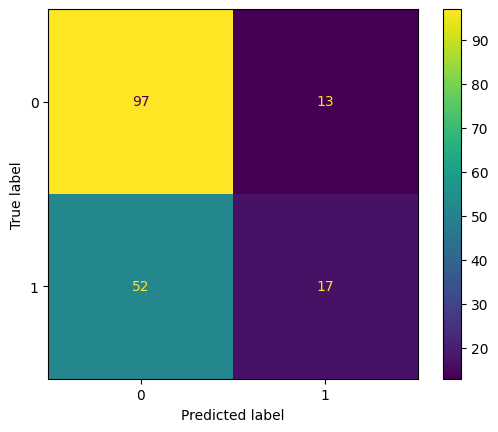

KNeighborsClassifier(metric='euclidean', n_neighbors=15, weights='distance')

In [26]:
from sklearn.neighbors import KNeighborsClassifier

execute_ml(
    KNeighborsClassifier(
        **{'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'distance'}
    )
)

### Logistic regression

#### Hyperparameter Tuning

In [27]:
from sklearn.linear_model import LogisticRegression

hyper_params = {}
hyper_params['C'] = np.logspace(-2, 2, 5, endpoint=True)
hyper_params['solver'] = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
hyper_params['penalty'] = ['none', 'l1', 'l2', 'elasticnet']

grid_search(LogisticRegression(), hyper_params)

/home/babak/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/babak/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/babak/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/babak/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/babak/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/babak/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:111

Maximum accuracy of 0.796059 was yielded using: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
{'C': 0.01, 'penalty': 'none', 'solver': 'newton-cg'} => 0.760591
{'C': 0.01, 'penalty': 'none', 'solver': 'lbfgs'} => 0.782266
{'C': 0.01, 'penalty': 'none', 'solver': 'liblinear'} => 0.000000
{'C': 0.01, 'penalty': 'none', 'solver': 'sag'} => 0.682759
{'C': 0.01, 'penalty': 'none', 'solver': 'saga'} => 0.682759
{'C': 0.01, 'penalty': 'l1', 'solver': 'newton-cg'} => 0.000000
{'C': 0.01, 'penalty': 'l1', 'solver': 'lbfgs'} => 0.000000
{'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'} => 0.689409
{'C': 0.01, 'penalty': 'l1', 'solver': 'sag'} => 0.000000
{'C': 0.01, 'penalty': 'l1', 'solver': 'saga'} => 0.689409
{'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'} => 0.696798
{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'} => 0.703941
{'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'} => 0.703941
{'C': 0.01, 'penalty': 'l2', 'solver': 'sag'} => 0.682759
{'C': 0.01, 'penalty': 'l2', 'solve

/home/babak/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/babak/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/babak/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/babak/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/babak/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/babak/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: Con

#### Train and test

              precision    recall  f1-score   support

           0       0.82      0.85      0.83       110
           1       0.74      0.70      0.72        69

    accuracy                           0.79       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.79      0.79      0.79       179



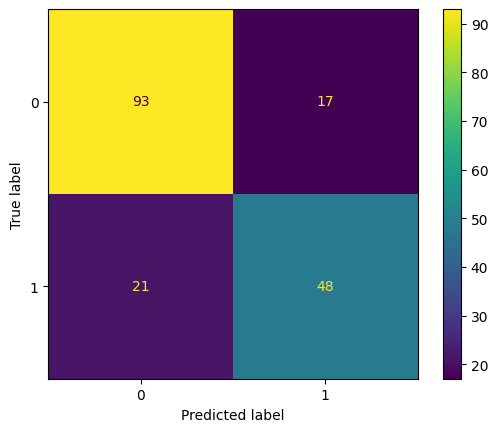

LogisticRegression(solver='liblinear')

In [29]:
from sklearn.linear_model import LogisticRegression

execute_ml(
    LogisticRegression(
        **{'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
    )
)

### Logistic regression CV

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       110
           1       0.73      0.71      0.72        69

    accuracy                           0.79       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.79      0.79      0.79       179



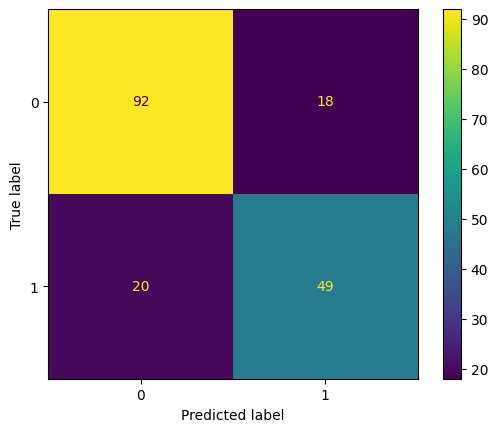

LogisticRegressionCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=10, random_state=12),
                     max_iter=1000, random_state=12)

In [30]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import RepeatedStratifiedKFold

execute_ml(LogisticRegressionCV(max_iter=1000,
                                cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=12),
                                random_state=12))

### Bernoulli Naive Bayes

#### Hyperparameter Tuning

In [31]:
from sklearn.naive_bayes import BernoulliNB

hyper_params = {}
hyper_params['alpha'] = list(np.logspace(-5, 5, num=11, endpoint=True)) + [0]

grid_search(BernoulliNB(), hyper_params)

Maximum accuracy of 0.796059 was yielded using: {'alpha': 1e-05}
{'alpha': 1e-05} => 0.796059
{'alpha': 0.0001} => 0.796059
{'alpha': 0.001} => 0.796059
{'alpha': 0.01} => 0.796059
{'alpha': 0.1} => 0.796059
{'alpha': 1.0} => 0.796059
{'alpha': 10.0} => 0.697783
{'alpha': 100.0} => 0.619704
{'alpha': 1000.0} => 0.619704
{'alpha': 10000.0} => 0.619704
{'alpha': 100000.0} => 0.619704
{'alpha': 0} => 0.796059


/home/babak/.local/lib/python3.10/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/home/babak/.local/lib/python3.10/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/home/babak/.local/lib/python3.10/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/home/babak/.local/lib/python3.10/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/home/babak/.local/lib/python3.10/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


#### Train and test

              precision    recall  f1-score   support

           0       0.82      0.80      0.81       110
           1       0.69      0.72      0.71        69

    accuracy                           0.77       179
   macro avg       0.76      0.76      0.76       179
weighted avg       0.77      0.77      0.77       179



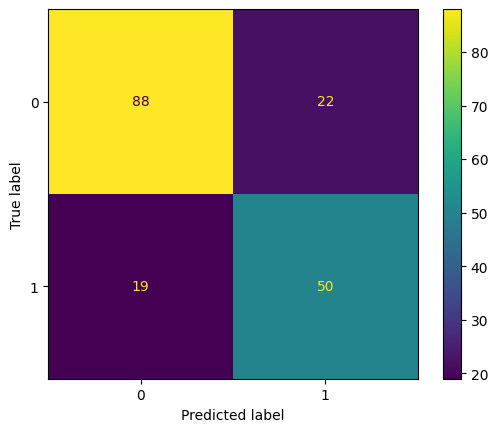

BernoulliNB(alpha=1e-05)

In [32]:
from sklearn.naive_bayes import BernoulliNB

execute_ml(
    BernoulliNB(
        **{'alpha': 1e-05}
    )
)

### Random forest

#### Hyperparameter Tuning

In [33]:
from sklearn.ensemble import RandomForestClassifier

hyper_params = {}
hyper_params['n_estimators'] = np.logspace(1, 3, 3, endpoint=True)
hyper_params['max_features'] = ['sqrt', 'log2']
hyper_params['criterion'] = ['gini', 'entropy']

grid_search(RandomForestClassifier(), hyper_params)

Maximum accuracy of 0.809606 was yielded using: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 10}
{'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 10} => 0.802217
{'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100} => 0.802217
{'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 1000} => 0.767488
{'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 10} => 0.774384
{'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100} => 0.767488
{'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 1000} => 0.774384
{'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 10} => 0.760099
{'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100} => 0.774384
{'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 1000} => 0.774384
{'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 10} => 0.809606
{'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 100} => 0.788424


#### Train and test

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       110
           1       0.82      0.74      0.78        69

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



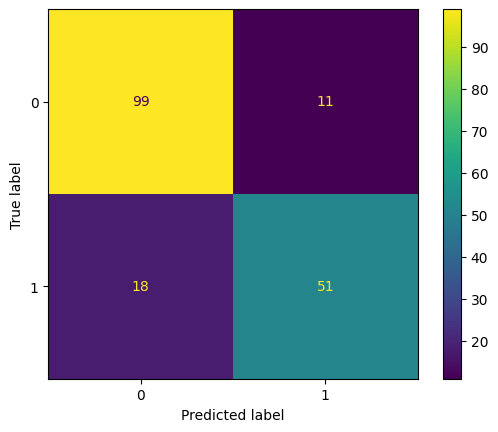

RandomForestClassifier(criterion='entropy', max_features='log2',
                       n_estimators=10)

In [34]:
from sklearn.ensemble import RandomForestClassifier

execute_ml(
    RandomForestClassifier(
        **{'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 10}
    )
)

### XGBoost classifier

#### Hyperparameter Tuning

In [37]:
from xgboost import XGBClassifier

hyper_params = {}
hyper_params['learning_rate'] = np.logspace(-3, 0, 4, endpoint=True)
hyper_params['n_estimators'] = np.logspace(1, 3, 3, endpoint=True)
hyper_params['max_depth'] = np.linspace(1,9, 5)
hyper_params['subsample'] = [0.1, 0.5, 0.7, 1.0]

grid_search(XGBClassifier(), hyper_params)

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__

Maximum accuracy of 0.837931 was yielded using: {'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 10, 'subsample': 0.5}
{'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 10, 'subsample': 0.1} => 0.746305
{'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 10, 'subsample': 0.5} => 0.796059
{'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 10, 'subsample': 0.7} => 0.796059
{'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 10, 'subsample': 1.0} => 0.796059
{'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 100, 'subsample': 0.1} => 0.711576
{'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 100, 'subsample': 0.5} => 0.796059
{'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 100, 'subsample': 0.7} => 0.796059
{'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 100, 'subsample': 1.0} => 0.796059
{'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 1000, 'subsample': 0.1} => 0.760345
{'learning_rate': 0.001, 'max_depth': 1, 'n_esti

#### Train and test

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       110
           1       0.83      0.70      0.76        69

    accuracy                           0.83       179
   macro avg       0.83      0.80      0.81       179
weighted avg       0.83      0.83      0.82       179



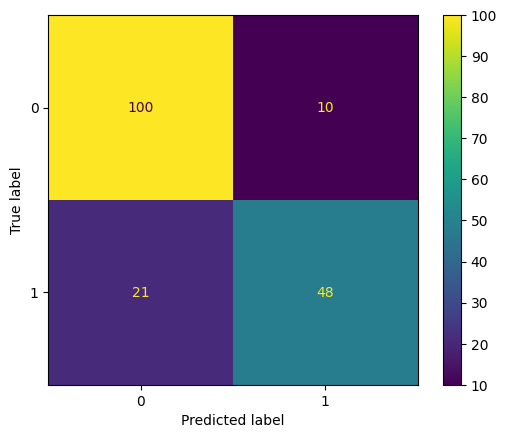

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.001, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [38]:
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

execute_ml(
    XGBClassifier(
        **{'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 10, 'subsample': 0.5}
    )
)

### HistGradientBoost classifier

#### Hyperparameter Tuning

In [45]:
from sklearn.ensemble import HistGradientBoostingClassifier

hyper_params = {}
hyper_params['max_iter'] = [100, 500, 1000, 1200, 1500]
hyper_params['learning_rate'] = np.logspace(-3, 0, 4, endpoint=True)
hyper_params['max_depth'] = [1, 3, 5, 7, 9]

grid_search(HistGradientBoostingClassifier(), hyper_params) 

Maximum accuracy of 0.831034 was yielded using: {'learning_rate': 0.001, 'max_depth': 3, 'max_iter': 1000}
{'learning_rate': 0.001, 'max_depth': 1, 'max_iter': 100} => 0.619704
{'learning_rate': 0.001, 'max_depth': 1, 'max_iter': 500} => 0.760345
{'learning_rate': 0.001, 'max_depth': 1, 'max_iter': 1000} => 0.803202
{'learning_rate': 0.001, 'max_depth': 1, 'max_iter': 1200} => 0.817488
{'learning_rate': 0.001, 'max_depth': 1, 'max_iter': 1500} => 0.817488
{'learning_rate': 0.001, 'max_depth': 3, 'max_iter': 100} => 0.619704
{'learning_rate': 0.001, 'max_depth': 3, 'max_iter': 500} => 0.816749
{'learning_rate': 0.001, 'max_depth': 3, 'max_iter': 1000} => 0.831034
{'learning_rate': 0.001, 'max_depth': 3, 'max_iter': 1200} => 0.809606
{'learning_rate': 0.001, 'max_depth': 3, 'max_iter': 1500} => 0.809606
{'learning_rate': 0.001, 'max_depth': 5, 'max_iter': 100} => 0.619704
{'learning_rate': 0.001, 'max_depth': 5, 'max_iter': 500} => 0.816749
{'learning_rate': 0.001, 'max_depth': 5, 'max_i

#### Train and test

              precision    recall  f1-score   support

           0       0.77      0.94      0.84       110
           1       0.84      0.55      0.67        69

    accuracy                           0.79       179
   macro avg       0.81      0.74      0.76       179
weighted avg       0.80      0.79      0.78       179



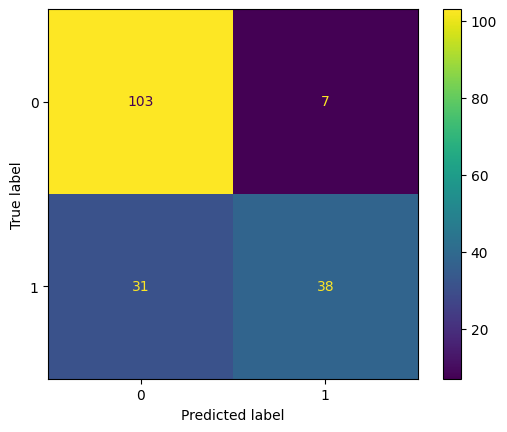

HistGradientBoostingClassifier(learning_rate=0.001, max_depth=3, max_iter=1000)

In [46]:
from sklearn.ensemble import HistGradientBoostingClassifier

execute_ml(
    HistGradientBoostingClassifier(
        **{'learning_rate': 0.001, 'max_depth': 3, 'max_iter': 1000}
    )
)

### LightGBM classifier

#### Hyperparameter Tuning

In [28]:
from lightgbm import LGBMClassifier

hyper_params = {}
hyper_params['n_estimators'] = [100, 500, 1000, 1200, 1500]
hyper_params['learning_rate'] = np.logspace(-3, 0, 4, endpoint=True)
hyper_params['boosting_type'] = ['gbdt', 'dart']

grid_search(LGBMClassifier(), hyper_params) 

Maximum accuracy of 0.823892 was yielded using: {'boosting_type': 'gbdt', 'learning_rate': 0.001, 'n_estimators': 500}
{'boosting_type': 'gbdt', 'learning_rate': 0.001, 'n_estimators': 100} => 0.619704
{'boosting_type': 'gbdt', 'learning_rate': 0.001, 'n_estimators': 500} => 0.823892
{'boosting_type': 'gbdt', 'learning_rate': 0.001, 'n_estimators': 1000} => 0.823892
{'boosting_type': 'gbdt', 'learning_rate': 0.001, 'n_estimators': 1200} => 0.795567
{'boosting_type': 'gbdt', 'learning_rate': 0.001, 'n_estimators': 1500} => 0.795567
{'boosting_type': 'gbdt', 'learning_rate': 0.01, 'n_estimators': 100} => 0.823892
{'boosting_type': 'gbdt', 'learning_rate': 0.01, 'n_estimators': 500} => 0.781527
{'boosting_type': 'gbdt', 'learning_rate': 0.01, 'n_estimators': 1000} => 0.774631
{'boosting_type': 'gbdt', 'learning_rate': 0.01, 'n_estimators': 1200} => 0.767734
{'boosting_type': 'gbdt', 'learning_rate': 0.01, 'n_estimators': 1500} => 0.760591
{'boosting_type': 'gbdt', 'learning_rate': 0.1, 'n

#### Train and test

              precision    recall  f1-score   support

           0       0.75      0.96      0.84       110
           1       0.89      0.49      0.64        69

    accuracy                           0.78       179
   macro avg       0.82      0.73      0.74       179
weighted avg       0.81      0.78      0.76       179



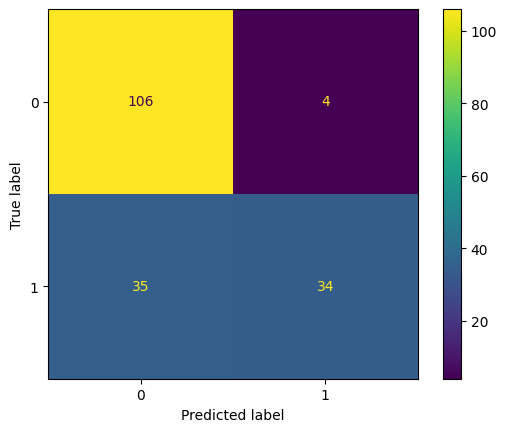

LGBMClassifier(learning_rate=0.001, n_estimators=500)

In [29]:
from lightgbm import LGBMClassifier

execute_ml(
    LGBMClassifier(
        **{'boosting_type': 'gbdt', 'learning_rate': 0.001, 'n_estimators': 500}
    )
)

### Support Vector Machine classifier

#### Hyperparameter Tuning

In [ ]:
from sklearn import svm

hyper_params = {}
hyper_params['C'] = np.logspace(-2, 2, 5, endpoint=True)
hyper_params['gamma'] = np.logspace(-3, 0, 4, endpoint=True)
hyper_params['kernel'] = ['linear', 'rbf', 'poly', 'sigmoid']

grid_search(svm.SVC(), hyper_params) 

#### Train and test

              precision    recall  f1-score   support

           0       0.66      0.92      0.77       110
           1       0.64      0.23      0.34        69

    accuracy                           0.65       179
   macro avg       0.65      0.58      0.55       179
weighted avg       0.65      0.65      0.60       179



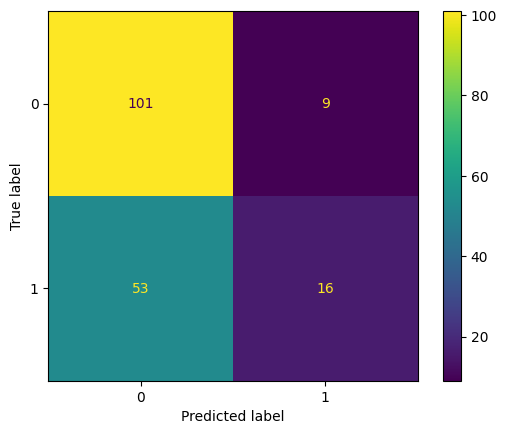

SVC()

In [31]:
from sklearn import svm

execute_ml(
    svm.SVC(
    )
)

### Bagging classifier

              precision    recall  f1-score   support

           0       0.84      0.91      0.87       110
           1       0.83      0.72      0.78        69

    accuracy                           0.84       179
   macro avg       0.84      0.82      0.82       179
weighted avg       0.84      0.84      0.84       179



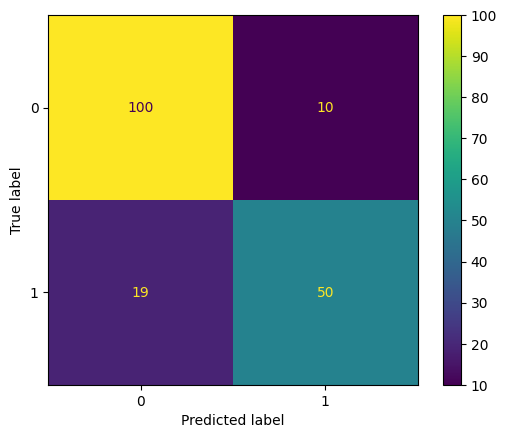

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_features=0.8,
                  max_samples=0.8, n_estimators=200, oob_score=True,
                  random_state=12)

In [160]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

execute_ml(
    BaggingClassifier(
        DecisionTreeClassifier(),
        n_estimators=200,
        max_samples=0.8,
        max_features=0.8,
        oob_score=True,
        random_state=12
    )
)

### Multilayer perceptron

              precision    recall  f1-score   support

           0       0.88      0.77      0.82       110
           1       0.70      0.83      0.75        69

    accuracy                           0.79       179
   macro avg       0.79      0.80      0.79       179
weighted avg       0.81      0.79      0.80       179



C:\Users\Babak\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


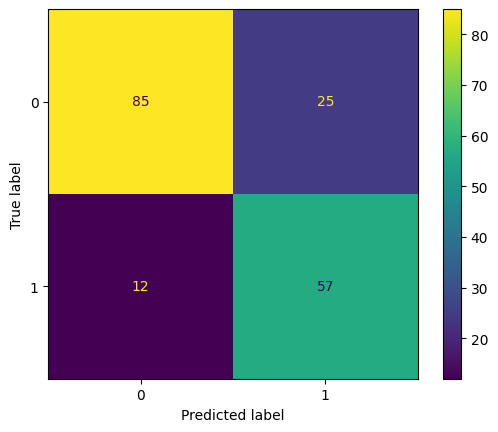

MLPClassifier(activation='logistic', random_state=12)

In [161]:
from sklearn.neural_network import MLPClassifier

execute_ml(MLPClassifier(hidden_layer_sizes=(100,), activation='logistic', solver='adam', random_state=12),
           X_train, y_train, X_test, y_test)

## Evaluation

In [58]:
evaluation_df

,Model,accuracy score,Precision,Recall,f1_score
0,KNeighborsClassifier,0.636872,0.566667,0.246377,0.343434
1,LogisticRegression,0.787709,0.738462,0.695652,0.716418
2,LogisticRegressionCV,0.787709,0.731343,0.710145,0.720588
3,BernoulliNB,0.770950,0.694444,0.724638,0.709220
4,RandomForestClassifier,0.837989,0.822581,0.739130,0.778626
5,GradientBoostingClassifier,0.810056,0.872340,0.594203,0.706897
6,XGBClassifier,0.826816,0.827586,0.695652,0.755906
7,HistGradientBoostingClassifier,0.782123,0.727273,0.695652,0.711111
8,HistGradientBoostingClassifier,0.787709,0.844444,0.550725,0.666667
9,LGBMClassifier,0.782123,0.894737,0.492754,0.635514


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [

## Overfit analysis using cross validation

Cross validating the training VS testing performance using the selected model. If the measurements are not that far apart means that there is not a considerable overfit.

In [163]:
from sklearn.ensemble import RandomForestClassifier

perform_cross_validation(
    RandomForestClassifier(bootstrap = True,
                           criterion='entropy',
                           verbose=1,
                           oob_score=True,
                           max_features = 'sqrt',
                           random_state=12),
    X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

{'fit_time': array([0.2387681 , 0.27867055, 0.2823627 , 0.24655318, 0.21589994]),
 'score_time': array([0.00610113, 0.01900625, 0.01600075, 0.01562715, 0.0156424 ]),
 'test_score': array([0.83916084, 0.8041958 , 0.80985915, 0.84507042, 0.78873239]),
 'train_score': array([1., 1., 1., 1., 1.])}

## Threshold tweaking

Checking the performance agaist different thresholds (extracted from the ROC curve) in order to find and optimum with regards to the case study (Whether it is more important to classify Positives or Negatives)

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       110
           1       0.84      0.74      0.78        69

    accuracy                           0.84       179
   macro avg       0.84      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



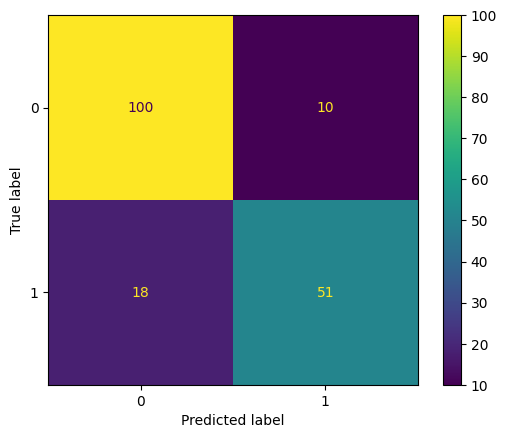

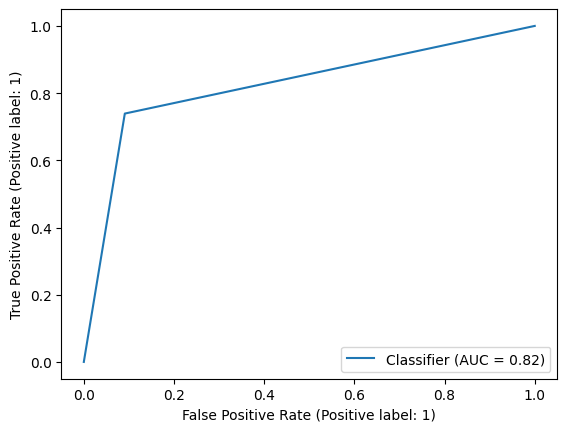

Threshold: 0.100000
              precision    recall  f1-score   support

           0       0.89      0.36      0.52       110
           1       0.48      0.93      0.63        69

    accuracy                           0.58       179
   macro avg       0.68      0.65      0.57       179
weighted avg       0.73      0.58      0.56       179



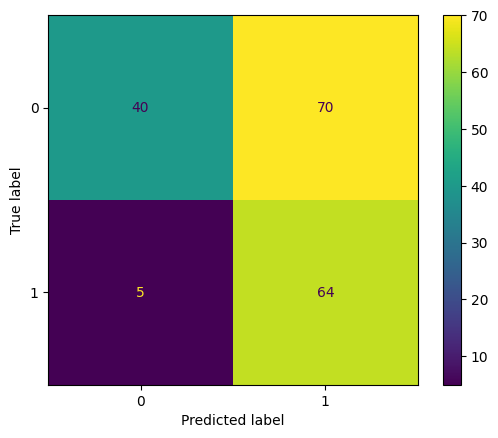

Threshold: 0.300000
              precision    recall  f1-score   support

           0       0.91      0.74      0.81       110
           1       0.68      0.88      0.77        69

    accuracy                           0.79       179
   macro avg       0.79      0.81      0.79       179
weighted avg       0.82      0.79      0.80       179



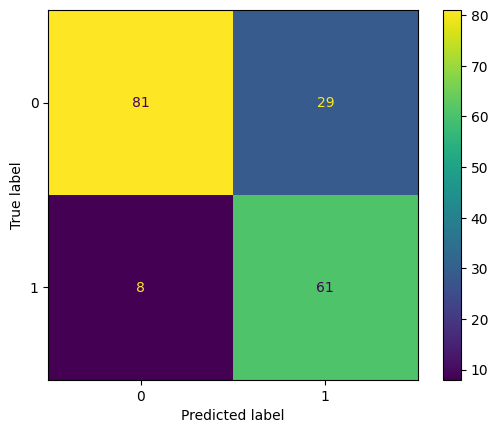

Threshold: 0.500000
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       110
           1       0.84      0.74      0.78        69

    accuracy                           0.84       179
   macro avg       0.84      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



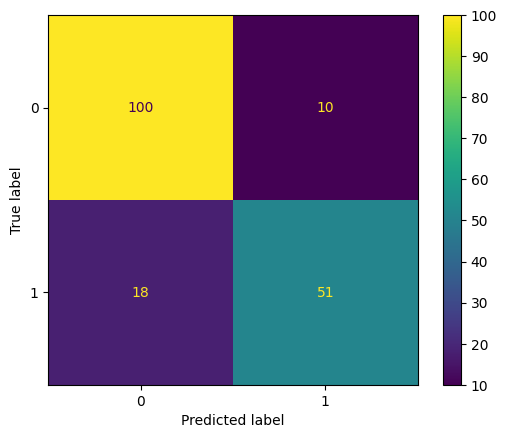

Threshold: 0.700000
              precision    recall  f1-score   support

           0       0.78      0.95      0.86       110
           1       0.89      0.58      0.70        69

    accuracy                           0.81       179
   macro avg       0.84      0.77      0.78       179
weighted avg       0.82      0.81      0.80       179



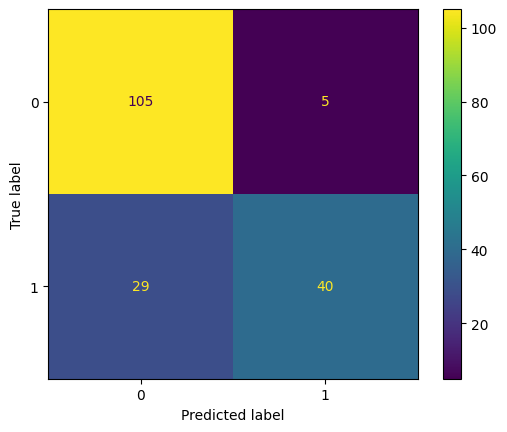

Threshold: 0.900000
              precision    recall  f1-score   support

           0       0.68      0.98      0.80       110
           1       0.90      0.26      0.40        69

    accuracy                           0.70       179
   macro avg       0.79      0.62      0.60       179
weighted avg       0.76      0.70      0.65       179



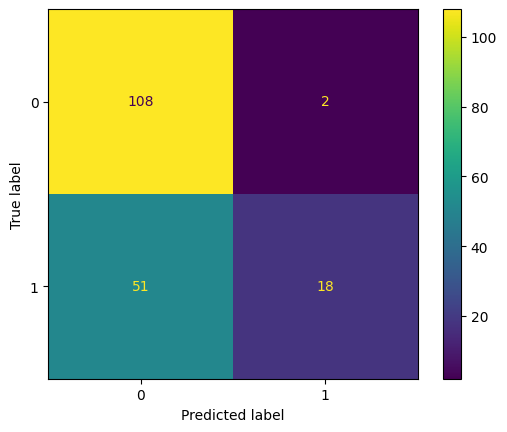

In [164]:
from sklearn.ensemble import RandomForestClassifier

model = execute_ml(RandomForestClassifier(bootstrap = True,
                                  criterion='entropy',
                                  max_features = 'sqrt',
                                  random_state=12),
                   X_train, y_train, X_test, y_test)

drawROC(model, X_test, y_test)

for i in np.arange(0.1,1,0.2):
    execute_using_threshold(
        RandomForestClassifier(bootstrap = True,
                               criterion='entropy',
                               max_features = 'sqrt',
                               random_state=12),
        X_train, y_train,
        i)